<a href="https://colab.research.google.com/github/sl-93/ECG_SSCL/blob/main/ECG_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Hello**

**In this notebook, I'll show you the implementation of CNN-Contrastive Model on MIT-BIH data.**

Let's kick off! :)

# 1.  What is the intuition behind Self-Supervised Contrastive Learning(SSCL)?
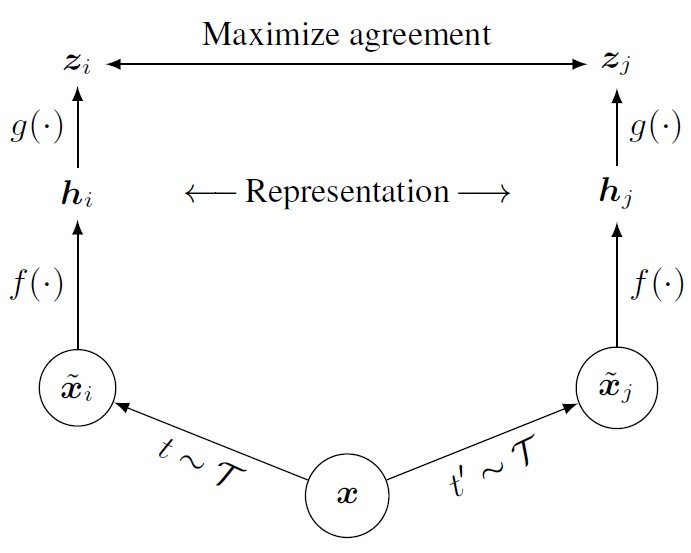

Well, as you see in the picture above, it is a framework for SSCL. in this framework, the training proccess is done with unlabeled data.

Let's check it step by step:

1.   The data is augmented and this leads to generation of two views **xi** and **xj**.
2.   An encoder(here is a CNN) gets **xi** and **xj** and produces **hi** and **hj** as its output.
3.   **hi** and **hj** are mapped into latent space with a linear layer and two vectors **zi** and **zj** are generated.
4.   At the end, the agreement between **zi** and **zj** is increased by the formula below:

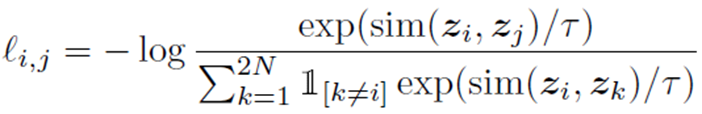

Where sim(.,.) is Cosine similarity. 

In order to train, each batch of unlabeled data with a size of N is augmented to produce 2N samples and then the Contrastive loss between the latent representations corresponding to **xi** and **xj** which are considered as a positive pair is calculated with the formula above.

I'd like to mention that, I'm going to use the Train set for training the encoder and the Test set for fine-tuning the model.


# 2. Let's get more familiar with the data!

**Heads-up**: I read the data from my Drive so it's not accessible for you as a reader!

In [ ]:
import pandas as pd

# read data
train_df = pd.read_csv("/content/drive/MyDrive/ECG-data/mitbih_train.csv",header = None)
test_df = pd.read_csv("/content/drive/MyDrive/ECG-data/mitbih_test.csv",header = None)

In [ ]:
train_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87549,0.807018,0.494737,0.536842,0.529825,0.491228,0.484211,0.456140,0.396491,0.284211,0.136842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87550,0.718333,0.605000,0.486667,0.361667,0.231667,0.120000,0.051667,0.001667,0.000000,0.013333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87551,0.906122,0.624490,0.595918,0.575510,0.530612,0.481633,0.444898,0.387755,0.322449,0.191837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87552,0.858228,0.645570,0.845570,0.248101,0.167089,0.131646,0.121519,0.121519,0.118987,0.103797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


As you see, the Train file consists of 87554 records with 187 features. The last column is associated with the class name. This dataset has 5 different classes. All features has been normalized between 0 and 1.

**We know that each record represents one heart beat with the sample rate of 125.**

In [ ]:
test_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21887,0.928736,0.871264,0.804598,0.742529,0.650575,0.535632,0.394253,0.250575,0.140230,0.102299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
21888,0.802691,0.692078,0.587444,0.446936,0.318386,0.189836,0.118087,0.077728,0.112108,0.152466,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
21889,1.000000,0.967359,0.620178,0.347181,0.139466,0.089021,0.103858,0.100890,0.106825,0.100890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
21890,0.984127,0.567460,0.607143,0.583333,0.607143,0.575397,0.575397,0.488095,0.392857,0.238095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


And Test file is made up of 21892 records.

In [ ]:
# split x and y
x_train = train_df.iloc[:,:-1]
y_train = train_df.iloc[:,-1]
x_test = test_df.iloc[:,:-1]
y_test = test_df.iloc[:,-1]

Let's plot 20 records of each class!

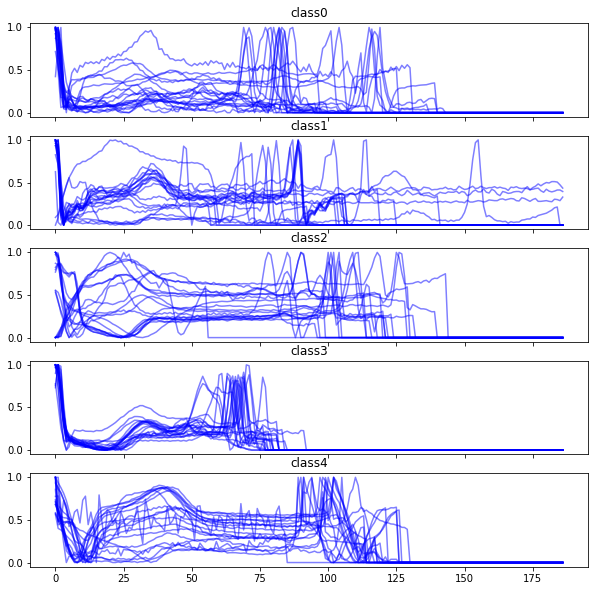

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

f, ax = plt.subplots(5, sharex=True, sharey=True, figsize=(10,10))
for i in range(5):
  for j in range(20):
    ax[i].set_title("class{}".format(i))
    ax[i].plot(x_train[y_train == i].iloc[j,:], color="blue", alpha=.5)

It seems that each class has the unique pattern of beat through time!

And the distribution of the samples across the classes:

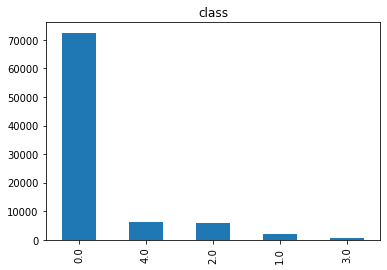

In [ ]:
y_train.value_counts().plot(kind="bar", title="class")

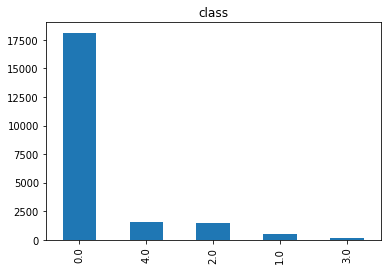

In [ ]:
y_test.value_counts().plot(kind="bar", title="class")

**The Data is highly unbalanced!**

It's time to take advantage of Deep Learning to classify the data...

# 3. We'll create dataloader and use Masking method for data augmentation.

For augmentation I'll use Masking method. Predefined percentage of input pattern features are randomly masked. This parameter is adjustable in its function, but I set it to 10% by default. As I mentioned earlier, the Train set is used to train the encoder.

It's mentionable that I'll use 95% and 5% for training and evaluation respectively.

In [ ]:
# a function for masking the data
import numpy as np

def masking(x_data, percentage):
  for i in range(len(x_data)):
    indices = np.random.choice(np.arange(x_data[i].size), replace=False,
                           size=int(x_data[i].size * percentage))
    x_data[i][indices] = 0
  return x_data

In [ ]:
# a function for creating dataloader
from torch import Tensor
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split

def Create_Dataloader(train_data, batch_size, percentage):

  # read the data
  train_ds = pd.read_csv(train_data, header = None)

  # shuffle the data
  train_ds = train_ds.sample(frac = 1)

  # drop label
  x_train = train_ds.iloc[:,:-1]
  y_train = train_ds.iloc[:,-1]

  # train, valid, test split
  x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=.05, random_state=42)
  x_train = np.array(x_train)
  x_valid = np.array(x_valid)

  # masking
  trainX1 = masking(x_train, percentage)
  trainX2 = masking(x_train, percentage)
  validX1 = masking(x_valid, percentage)
  validX2 = masking(x_valid, percentage)

  # reshape the data
  X_train1 = np.reshape(trainX1, (trainX1.shape[0], trainX1.shape[1], 1))
  X_train2 = np.reshape(trainX2, (trainX2.shape[0], trainX2.shape[1], 1))
  X_valid1 = np.reshape(validX1, (validX1.shape[0], validX1.shape[1], 1))
  X_valid2 = np.reshape(validX2, (validX2.shape[0], validX2.shape[1], 1))

  # Create the DataLoader for the data
  X_train1 = torch.tensor(X_train1)
  X_train2 = torch.tensor(X_train2)
  X_valid1 = torch.tensor(X_valid1)
  X_valid2 = torch.tensor(X_valid2)

  train_data = TensorDataset(X_train1, X_train2)
  valid_data = TensorDataset(X_valid1, X_valid2)

  train_sampler = RandomSampler(train_data)
  valid_sampler = RandomSampler(valid_data)

  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
  valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_size)

  return train_dataloader, valid_dataloader


# 4. Defining the model's architecture and training.

As I mentioned earlier, we need an encoder to generate latent representations of data. I use CNN as an encoder which is made up of 5 convolution layers and 1 linear layer. 

In [ ]:
# model architecture
import torch.nn as nn

class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        
        # 187 x 1
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=2, stride=1, padding=0),
            nn.BatchNorm1d(32),
            nn.ReLU())
        
        # 186 x 32
        self.conv2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm1d(64),
            nn.ReLU())
        
        # 93 x 64
        self.conv3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=2, stride=1, padding=0),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(4, stride=4))
        
        # 23 x 128
        self.conv4 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3, stride=3))
        
        # 7 x 256
        self.conv5 = nn.Sequential(
            nn.Conv1d(256, 512, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.MaxPool1d(5, stride=5))
        
        # 1 x 512
        self.projection = nn.Linear(512, 256)

    
    def forward(self, x):
        # expected conv1d input : minibatch_size x num_channel x width
        x = x.view(x.shape[0], 1,-1)

        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)

        out_f = out.view(x.shape[0], out.size(1) * out.size(2))
        logit = self.projection(out_f)
        
        return logit

In [ ]:
# A class for contrastive loss
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature, batch_size):
        super(ContrastiveLoss, self).__init__()
        self.batch_size = batch_size
        self.temperature = temperature

        self.mask = self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):

        N = 2 * self.batch_size

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)
        
        # We have 2N samples, but with Distributed training every GPU gets N examples too, resulting in: 2xNxN
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[self.mask].reshape(N, -1)
        
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long()
        
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        
        return loss

In [ ]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [ ]:
# Initialize the Classifier and the optimizer.
def initialize_model():

    # Instantiate model
    model_classifier = CNN_Model()

    # Tell PyTorch to run the model on GPU
    model_classifier.to(device)

    # Create the optimizer
    optimizer = torch.optim.AdamW(model_classifier.parameters(), lr=0.0002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    return model_classifier, optimizer, scheduler

In [ ]:
# After the completion of each training epoch, measure the model's performance on our validation set.
def evaluate(model, val_dataloader, tem):

    val_loss = 0
    model.eval()
    with torch.no_grad():
        val_loss_epoch = 0
        
        for step, (x_i, x_j) in enumerate(val_dataloader):
          criterion = ContrastiveLoss(batch_size = len(x_i), temperature = 0.5)
          x_i = x_i.squeeze().to('cuda:0').float()
          x_j = x_j.squeeze().to('cuda:0').float()

          # positive pair, with encoding
          z_i = model(x_i)
          z_j = model(x_j)

          val_loss += criterion(z_i, z_j).cpu()

    # Compute the average loss over the validation set.
    val_loss = val_loss / len(val_dataloader)

    return val_loss

In [ ]:
import random
import time

# A function for training
def train(model, optimizer,scheduler, temperature, ep, train_dataloader, val_dataloader=None, evaluation=False):

    # Start training loop
    print("Start training...\n")
    val_list = []
    train_list = []
    best_val_loss = float('inf')
    # Print the header of the result table
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Elapsed':^9}")
    print("-"*47)

    for e in range(1,ep + 1):
        # =======================================
        #               Training
        # =======================================

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()
        
        # For each batch of training data...
        train_accuracy = []
        for batch, (x_i, x_j) in enumerate(train_dataloader):
            criterion = ContrastiveLoss(batch_size = len(x_i), temperature = 0.5)
            batch_counts +=1
            optimizer.zero_grad()

            # Load batch to GPU
            x_i = x_i.squeeze().to('cuda:0').float()
            x_j = x_j.squeeze().to('cuda:0').float()

            # positive pair, with encoding
            z_i = model(x_i)
            z_j = model(x_j)

            # calculate loss
            loss = criterion(z_i, z_j)
            loss.backward()
            optimizer.step()

            # Zero out any previously calculated gradients
            model.zero_grad()

            batch_loss += loss.item()
            total_loss += loss.item()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Reset batch tracking variables
        batch_loss, batch_counts = 0, 0
        t0_batch = time.time()
        scheduler.step()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)
        train_list.append(avg_train_loss)

        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss = evaluate(model, val_dataloader, temperature)
            val_list.append(val_loss)

            time_elapsed = time.time() - t0_epoch

  
            # print result table
            print(f"{e:^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {time_elapsed:^9.2f}")
            print("-"*47)
        #print("\n")
    torch.save(model.state_dict(), '/content/pre_model.pt')
    
    print("\n")
    # plot train and valid loss
    plt.plot(list(range(len(val_list))), val_list, label = "validation loss")
    plt.plot(list(range(len(train_list))), train_list, label = "training loss")
    plt.title('loss')
    plt.xlabel('number of epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
    print("\n")
    
    print("Training complete!")

In [ ]:
# A function for setting seed
def set_seed(seed_value):

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [ ]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)
# initialize model
model, optimizer, scheduler = initialize_model()

In [ ]:
train_path = "/content/drive/MyDrive/ECG-data/mitbih_train.csv"
batch_size = 64
percentage = 0.1
train_dataloader, val_dataloader = Create_Dataloader(train_path, batch_size, percentage)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Elapsed 
-----------------------------------------------
   1    |   2.906650   |  2.950559  |   25.14  
-----------------------------------------------
   2    |   2.890989   |  2.924983  |   23.05  
-----------------------------------------------
   3    |   2.888429   |  2.925665  |   22.94  
-----------------------------------------------
   4    |   2.886596   |  2.915095  |   22.84  
-----------------------------------------------
   5    |   2.885274   |  2.914587  |   25.45  
-----------------------------------------------
   6    |   2.884093   |  2.911564  |   24.10  
-----------------------------------------------
   7    |   2.883039   |  2.909435  |   23.07  
-----------------------------------------------
   8    |   2.882301   |  2.903819  |   23.11  
-----------------------------------------------
   9    |   2.881572   |  2.900838  |   23.12  
-----------------------------------------------
  10    |   2.880906 

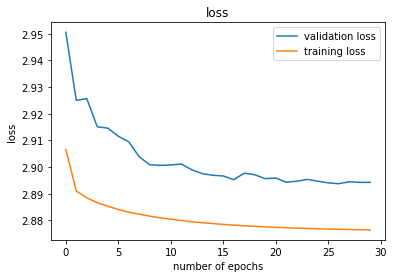



Training complete!


In [ ]:
# training pretrained model
temprature = 0.5
epoch = 30
train(model, optimizer, scheduler, temprature, epoch, train_dataloader, val_dataloader, evaluation=True)

This is the result of training the encoder after 30 epochs.

In [ ]:
# load pretrained model and tune for classification
model = CNN_Model()
model.load_state_dict(torch.load('/content/pre_model.pt'))

<All keys matched successfully>

# 5. Evaluating the trined encoder

In order to evaluate the encoder I'm going to use TSNE plot. This plot will tell us that how good the encoder can be in seperating the data. I'll randomly use some samples of the Test set for this pupose.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# A function for plotting TSNE
def Plot_TSNE(test_df, num):

  a = pd.DataFrame()
  test_df = test_df.sample(frac = 1)
  x_test = test_df.iloc[:,:-1]
  y_test = test_df.iloc[:,-1]
  for i in range(num):
    x = np.array(x_test.iloc[i, :])
    x = np.reshape(x, (1, x.shape[0], 1))
    x = torch.tensor(x)
    y = model(x.float())
    a = pd.concat([a,pd.DataFrame(y.cpu().detach().numpy())])
  X = a
  y = y_test[:num].values.reshape(-1,).tolist()

  tsne = TSNE(n_components=2, random_state=0)
  X_2d = tsne.fit_transform(X)
  y = np.array(y)

  target_names = np.array(['0','1','2','3','4'])
  target_ids = range(len(target_names))

  plt.figure(figsize=(10, 10))
  colors = 'r', 'b','g','c','m'
  for i, c, label in zip(target_ids, colors, target_names):
      plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=c, label=label)
  plt.legend()
  plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


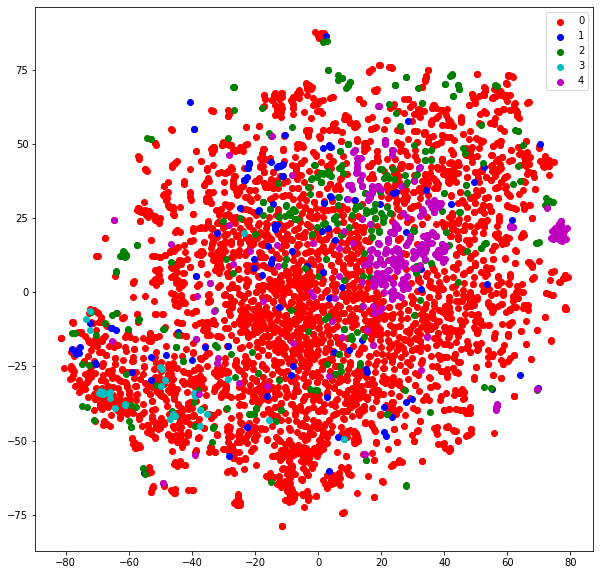

In [ ]:
# I plot 5000 samples of test set by default
num_samples = 5000
Plot_TSNE(test_df, num_samples)

Huuum! It's not that bad! :))

# 6. Fine-tuning the Model.

Well, in this last step, I'll freeze the encoder parameters and then I'll add a linear layer to it. After that, I'm going to fine-tune the whole model with the Test set.

I should mention that, I'll use 90% and 10% of the Test set for fine-tuning and evaluation respectively.

In [ ]:
class DSModel(nn.Module):
    def __init__(self,premodel,num_classes):
        super().__init__()
        
        self.premodel = premodel
        self.num_classes = num_classes
        
        # freeze pretrained model's parameters
        for p in self.premodel.parameters():
            p.requires_grad = False
        
        self.lastlayer = nn.Linear(256,self.num_classes)
        
    def forward(self,x):
        out = self.premodel(x)
        out = self.lastlayer(out)
        return out

In [ ]:
def init_model(model, num_class):
    """Initialize the Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate model
    model_final = DSModel(model, num_class)

    # Create the optimizer
    optimizer = torch.optim.AdamW(model_final.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

    return model_final, optimizer

In [ ]:
def Create_Dataloader_final(test_data, batch_size):

  # read data
  test_ds = pd.read_csv(test_data, header = None)

  # shuffle data
  test_df = test_ds.sample(frac = 1)

  # droped label
  x_test = test_df.iloc[:,:-1]
  y_test = test_df.iloc[:,-1]

  # train, valid, test split
  X_train, X_valid, y_train, y_valid = train_test_split(x_test, y_test, test_size=.1, random_state=42)
  x_train = np.array(X_train)
  x_valid = np.array(X_valid)
  y_train = np.array(y_train)
  y_valid = np.array(y_valid)


  # reshaping data
  X_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
  X_valid = np.reshape(x_valid, (x_valid.shape[0],x_valid.shape[1],1))

  # Create the DataLoader for our data
  X_train = torch.tensor(X_train)
  X_valid = torch.tensor(X_valid)
  y_train = torch.tensor(y_train)
  y_valid = torch.tensor(y_valid)

  train_data = TensorDataset(X_train, y_train)
  valid_data = TensorDataset(X_valid, y_valid)

  train_sampler = RandomSampler(train_data)
  valid_sampler = RandomSampler(valid_data)

  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
  valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_size)

  return train_dataloader, valid_dataloader


In [ ]:
def final_evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    model.eval()
    loss_sublist = np.array([])
    acc_sublist = np.array([])
    f1_sublist = np.array([])
    loss_fn = nn.CrossEntropyLoss()

    with torch.no_grad():
       for x,y in val_dataloader:

            z = model(x.float())

            # Compute the average loss over the validation set.
            val_loss = loss_fn(z,y.squeeze(-1).type(torch.LongTensor))

            # model's prediction
            preds = torch.exp(z.cpu().data)/torch.sum(torch.exp(z.cpu().data))

            loss_sublist = np.append(loss_sublist, val_loss.cpu().data)
            acc_sublist = np.append(acc_sublist,np.array(np.argmax(preds,axis=1)==y.cpu().data.view(-1)).astype('int'),axis=0)
            f1 = f1_score(y.cpu().data.view(-1), np.array(np.argmax(preds,axis=1)), average='weighted')
            f1_sublist = np.append(f1_sublist, f1)

    return np.mean(loss_sublist), np.mean(acc_sublist), np.mean(f1_sublist)

In [ ]:
from sklearn.metrics import f1_score
def final_train(model, optimizer, ep, train_dataloader_final, val_dataloader_final, evaluation=False):
    """Train the final model.
    """

    # Start training loop
    print("Start training...\n")
    tr_ep_loss = []
    tr_ep_acc = []
    tr_ep_f1 = []
    val_ep_loss = []
    val_ep_acc = []
    val_ep_f1 = []
    loss_fn = nn.CrossEntropyLoss()

    # print the headers
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Train accuracy':^12} | {'Train F1 score':^12} | {'Val Loss':^10} | {'Val accuuracy':^10} | {'Val F1 score':^10} | {'Elapsed':^9}")
    print("-"*112)

    for e in range(1, ep + 1):
        # =======================================
        #               Training
        # =======================================

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()
        
        # For each batch of training data...
        loss_sublist = np.array([])
        acc_sublist = np.array([])
        f1_sublist = np.array([])

        for batch, (x, y) in enumerate(train_dataloader_final):
            batch_counts +=1
            optimizer.zero_grad()

            # model's output
            z = model_final(x.float())

            # calculate losst
            loss = loss_fn(z, y.squeeze(-1).type(torch.LongTensor))
            loss.backward()

            preds = torch.exp(z.cpu().data)/torch.sum(torch.exp(z.cpu().data))
            f1 = f1_score(y.cpu().data.view(-1), np.array(np.argmax(preds,axis=1)), average='weighted')

            f1_sublist = np.append(f1_sublist, f1)
            loss_sublist = np.append(loss_sublist, loss.cpu().data)
            acc_sublist = np.append(acc_sublist,np.array(np.argmax(preds,axis=1)==y.cpu().data.view(-1)).astype('int'),axis=0)
            optimizer.step()

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Reset batch tracking variables
        batch_loss, batch_counts = 0, 0
        t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = np.mean(loss_sublist)
        tr_ep_loss.append(avg_train_loss)
        avg_train_accuracy = np.mean(acc_sublist)
        tr_ep_acc.append(avg_train_accuracy)
        avg_train_f1 = np.mean(f1_sublist)
        tr_ep_f1.append(avg_train_f1)

        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy, val_f1 = final_evaluate(model, val_dataloader_final)
            val_ep_loss.append(val_loss)
            val_ep_acc.append(val_accuracy)
            val_ep_f1.append(val_f1)

            time_elapsed = time.time() - t0_epoch

            # Print the results
            print(f"{e:^7} | {avg_train_loss:^12.6f} | {avg_train_accuracy:^14.6} | {avg_train_f1:^14.6} | {val_loss:^10.6f} | {val_accuracy:^13.2f} | {val_f1:^13.2f} | {time_elapsed:^9.2f}")
            print("-"*112)

    torch.save(model.state_dict(), '/content/final_model.pt')
    print("\n")
    # plot train and valid loss
    plt.plot(list(range(len(val_ep_loss))), val_ep_loss, label = "validation loss")
    plt.plot(list(range(len(tr_ep_loss))), tr_ep_loss, label = "training loss")
    plt.title('loss')
    plt.xlabel('number of epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
    print("\n")

    # plot train and valid accuracy
    plt.plot(list(range(len(val_ep_acc))), val_ep_acc, label = "validation accuracy")
    plt.plot(list(range(len(tr_ep_acc))), tr_ep_acc, label = "training accuracy")
    plt.title('accuracy')
    plt.xlabel('number of epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()
    print("\n")

    # plot train and valid f1 score
    plt.plot(list(range(len(val_ep_f1))), val_ep_f1, label = "validation F1 Score")
    plt.plot(list(range(len(tr_ep_f1))), tr_ep_f1, label = "training F1 Score")
    plt.title('F1 Score')
    plt.xlabel('number of epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.show()
    print("\n")

    print("Training complete!")


In [ ]:
# create data 
test_path = "/content/drive/MyDrive/ECG-data/mitbih_test.csv"
train_dataloader_final, val_dataloader_final = Create_Dataloader_final(test_path, batch_size)

In [ ]:
model_final, optimizer2 = init_model(model, 5)

Start training...

 Epoch  |  Train Loss  | Train accuracy | Train F1 score |  Val Loss  | Val accuuracy | Val F1 score |  Elapsed 
----------------------------------------------------------------------------------------------------------------
   1    |   0.742118   |    0.804588    |    0.822106    |  0.468855  |     0.89      |     0.89      |   10.36  
----------------------------------------------------------------------------------------------------------------
   2    |   0.425710   |    0.889859    |    0.889302    |  0.368294  |     0.91      |     0.90      |   10.33  
----------------------------------------------------------------------------------------------------------------
   3    |   0.341997   |    0.91138     |    0.906577    |  0.314219  |     0.92      |     0.92      |   10.35  
----------------------------------------------------------------------------------------------------------------
   4    |   0.297423   |    0.922292    |    0.914848    |  0.280933  |   

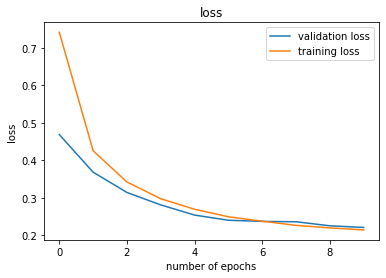

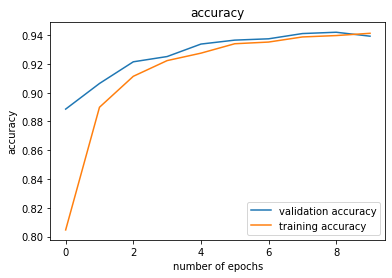

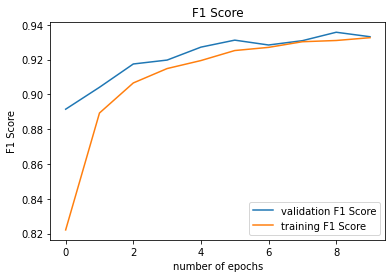



Training complete!


In [ ]:
# final training
epoch = 10
final_train(model_final, optimizer2, epoch, train_dataloader_final, val_dataloader_final, evaluation=True)

As it's shown, the accuracy and F1_score are about **94%**.

# 7. Conclusion.

In this work, I've tried to implement SSCL with the MIT-BIH dataset. 

This method is highly dependent on the number of unlabeled data. The more unlabeled data we have, the better model we've got.


This method is really suitable for generalization because after training the encoder we can fine-tune it with different datasets.


